In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from models.predictors import HandWinPredictor

In [2]:
df = pd.read_csv("data/hole_card_data.csv")

In [3]:
class PokerDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        attributes = [row['suited'], row['connectedness'], row['pair']]
        hand_idx = row['hand_idx']
        win_percentage = row['river_win_rate']*100
        return (
            torch.tensor(hand_idx, dtype=torch.long),
            torch.tensor(attributes, dtype=torch.float32), 
            torch.tensor(win_percentage, dtype=torch.float32)
            )

In [4]:
dataset = PokerDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
embedding_dim = 8
model = HandWinPredictor(card_embedding_dim=embedding_dim, hidden_dims=[64, 32, 16])
optimizer = torch.optim.Adam(params=model.parameters(), lr=.001)
loss_fn = nn.MSELoss()
epochs = 200

In [6]:
train_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        hole_card_idx, hole_card_attributes, targets = batch
        optimizer.zero_grad()
        outputs = model(hole_card_idx, hole_card_attributes)
        loss = loss_fn(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
            
        total_loss += loss.item()
    avg_loss = total_loss/len(dataloader)
    train_losses.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {round(avg_loss, 5)}")
    

Epoch 10/200, Loss: 2420.58378
Epoch 20/200, Loss: 2249.97842
Epoch 30/200, Loss: 2049.09032
Epoch 40/200, Loss: 1782.8218
Epoch 50/200, Loss: 1459.13604
Epoch 60/200, Loss: 1149.66341
Epoch 70/200, Loss: 845.98984
Epoch 80/200, Loss: 602.87762
Epoch 90/200, Loss: 398.80832
Epoch 100/200, Loss: 249.26149
Epoch 110/200, Loss: 134.34855
Epoch 120/200, Loss: 77.3972
Epoch 130/200, Loss: 41.17374
Epoch 140/200, Loss: 27.14235
Epoch 150/200, Loss: 16.165
Epoch 160/200, Loss: 15.74005
Epoch 170/200, Loss: 14.87088
Epoch 180/200, Loss: 13.25706
Epoch 190/200, Loss: 13.86765
Epoch 200/200, Loss: 17.4053


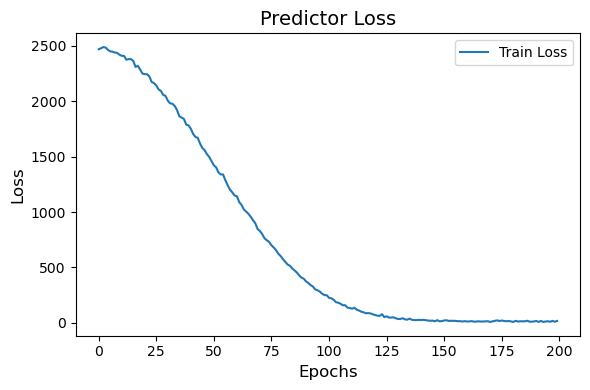

In [7]:
plt.figure(figsize=(6, 4))
sns.lineplot(x=list(range(epochs)), y=train_losses, label="Train Loss")
plt.title("Predictor Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10) 
plt.tight_layout()
plt.show()

In [22]:
torch.save(model.encoder.embedder.state_dict(), 'hand_embedding_weights/embeddings_model1.pt')